# sleep stage 예측

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 데이터 로드
file_path = 'train.csv'
data = pd.read_csv(file_path)

# 데이터셋의 기본 정보 확인
print(data.info())




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 4 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   id           1048575 non-null  int64  
 1   subjectID    1048575 non-null  int64  
 2   pulse        1048575 non-null  int64  
 3   sleep_stage  1047502 non-null  float64
dtypes: float64(1), int64(3)
memory usage: 32.0 MB
None


In [2]:
# 결측값 확인
print(data.isnull().sum())

id                0
subjectID         0
pulse             0
sleep_stage    1073
dtype: int64


**pulse 변수 분포 확인**

C:\Users\lee seung woo\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


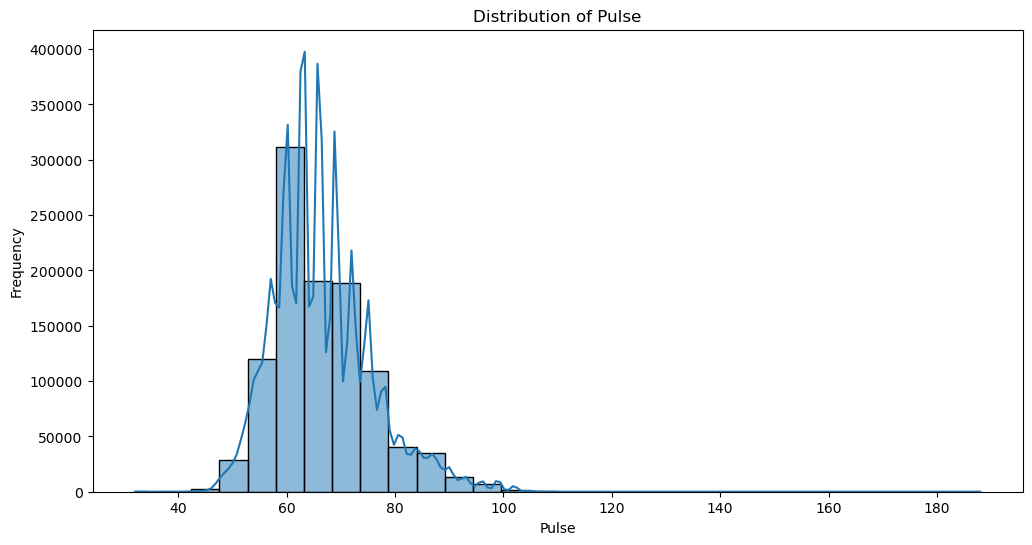

In [4]:
# Pulse 분포 플롯
plt.figure(figsize=(12, 6))
sns.histplot(data['pulse'], kde=True, bins=30)
plt.title('Distribution of Pulse')
plt.xlabel('Pulse')
plt.ylabel('Frequency')
plt.show()

**이상치 탐색을 위한 박스플롯**

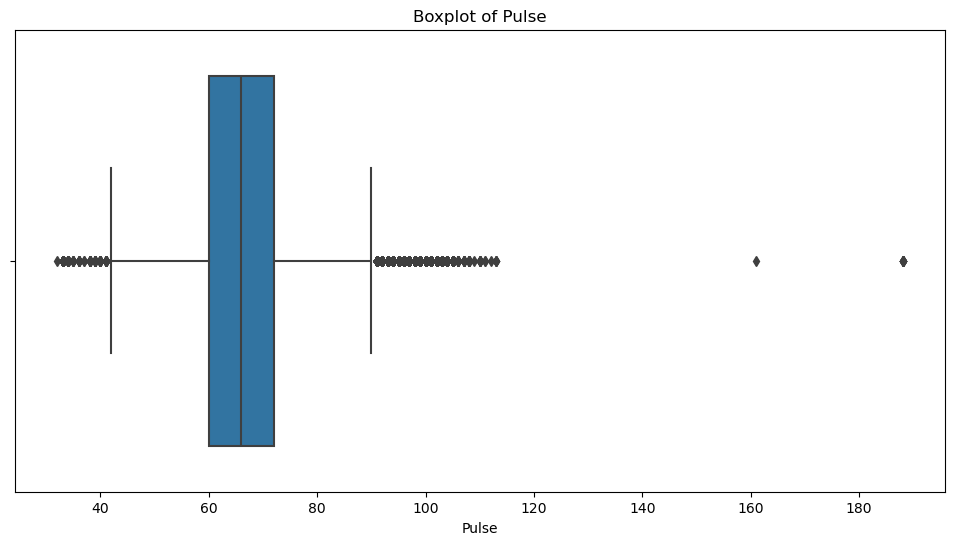

In [6]:
# Pulse 박스플롯
plt.figure(figsize=(12, 6))
sns.boxplot(x=data['pulse'])
plt.title('Boxplot of Pulse')
plt.xlabel('Pulse')
plt.show()

**가장 위쪽 데이터 2개의 이상치만 제거**

In [10]:
import pandas as pd


# 상위 2개의 점을 찾기
top_2_outliers = data['pulse'].nlargest(2)

# 상위 2개의 점을 제외한 데이터셋을 data_filtered로 저장
data_filtered = data[~data['pulse'].isin(top_2_outliers)]

# 결과 확인
print("제거 전 데이터 크기:", data.shape)
print("제거 후 데이터 크기:", data_filtered.shape)


제거 전 데이터 크기: (1048575, 4)
제거 후 데이터 크기: (1048565, 4)


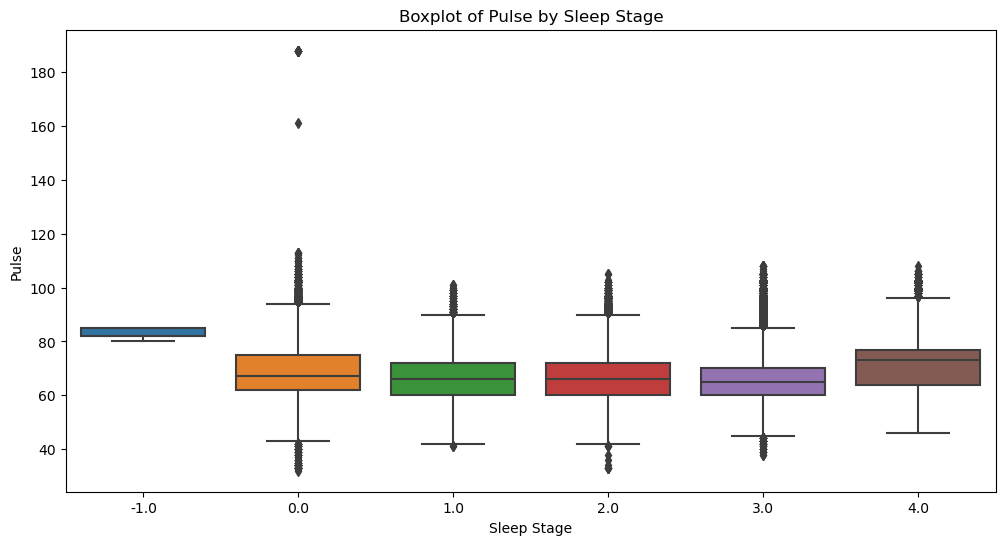

In [11]:
# sleep_stage와의 관계 분석
plt.figure(figsize=(12, 6))
sns.boxplot(x='sleep_stage', y='pulse', data=data)
plt.title('Boxplot of Pulse by Sleep Stage')
plt.xlabel('Sleep Stage')
plt.ylabel('Pulse')
plt.show()


> 4단계를 제외하고 수면단계가 -1~3단계 까지 평균적인 맥박수가 감소하는 것을 알 수 있다.

# data set 구성 sleep stage을 예측하기 위해 직전 29 time의 pulse을 이용한다.

In [15]:

from sklearn.preprocessing import MinMaxScaler

# 정규화 적용
scaler = MinMaxScaler()
data_filtered['normalized_pulse'] = scaler.fit_transform(data_filtered[['pulse']])

# 특성 생성 함수 정의
def create_lagged_features(df, lag=29):
    lagged_data = pd.DataFrame()
    for i in range(1, lag + 1):
        lagged_data[f'lag_{i}'] = df['normalized_pulse'].shift(i)
    lagged_data['sleep_stage'] = df['sleep_stage']
    lagged_data = lagged_data.dropna().reset_index(drop=True)
    return lagged_data

# 특성 생성 적용
lagged_data = data_filtered.groupby('subjectID').apply(create_lagged_features).reset_index(drop=True)

**data 크기를 고려하여 학습모델을 light gbm을 사용한다**

In [17]:
import lightgbm as lgb
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split

# 특성과 레이블 분리
X = lagged_data.drop('sleep_stage', axis=1)
y = lagged_data['sleep_stage']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# LightGBM 데이터셋 준비
train_data = lgb.Dataset(X_train, label=y_train)
valid_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

# 파라미터 설정
params = {
    'objective': 'multiclass',
    'num_class': len(y.unique()),  # sleep_stage의 클래스 수
    'metric': 'multi_logloss',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9
    }

## 모델 학습 

In [18]:
# 모델 학습
gbm = lgb.train(
    params,
    train_data,
    num_boost_round=100,
    valid_sets=[train_data, valid_data],
    early_stopping_rounds=10
)

# 예측
y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration)
y_pred = [list(x).index(max(x)) for x in y_pred]

# 성능 평가
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Classification Report:\n{report}")

C:\Users\lee seung woo\anaconda3\Lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.050579 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2136
[LightGBM] [Info] Number of data points in the train set: 837970, number of used features: 29
[LightGBM] [Info] Start training from score -1.655534
[LightGBM] [Info] Start training from score -2.046225
[LightGBM] [Info] Start training from score -1.679320
[LightGBM] [Info] Start training from score -0.740951
[LightGBM] [Info] Start training from score -4.096722
[1]	training's multi_logloss: 1.30538	valid_1's multi_logloss: 1.30648
Training until validation scores don't improve for 10 rounds
[2]	training's multi_logloss: 1.29854	valid_1's multi_logloss: 1.29976
[3]	training's multi_logloss: 1.29265	valid_1's multi_logloss: 1.29398
[4]	training's multi_logloss: 1.2874	valid_1's multi_logloss: 1.28882
[5]	training's multi_logloss: 1.2827	valid_1's multi_logloss: 1.2842
[6]	training's multi_log

# validation data에 대한 성능평가 

In [19]:
validation_data = pd.read_csv('validation.csv')

# 정규화 적용
scaler = MinMaxScaler()
data_filtered['normalized_pulse'] = scaler.fit_transform(data_filtered[['pulse']])

# 유효 데이터셋에도 동일한 정규화 적용
validation_data['normalized_pulse'] = scaler.transform(validation_data[['pulse']])

In [20]:
# 유효 데이터에 특성 생성 적용
validation_lagged_data = validation_data.groupby('subjectID').apply(create_lagged_features).reset_index(drop=True)

# 특성과 레이블 분리
X_val = validation_lagged_data.drop('sleep_stage', axis=1)
y_val = validation_lagged_data['sleep_stage']

# 예측
y_val_pred = gbm.predict(X_val, num_iteration=gbm.best_iteration)
y_val_pred_classes = [list(x).index(max(x)) for x in y_val_pred]

# 성능 평가
val_accuracy = accuracy_score(y_val, y_val_pred_classes)
val_report = classification_report(y_val, y_val_pred_classes)

print(f"Validation Accuracy: {val_accuracy}")
print(f"Validation Classification Report:\n{val_report}")

Validation Accuracy: 0.4584018750924896
Validation Classification Report:
              precision    recall  f1-score   support

         0.0       0.49      0.13      0.21    235783
         1.0       0.12      0.02      0.04    155164
         2.0       0.18      0.11      0.14    121443
         3.0       0.49      0.87      0.63    496123
         4.0       0.00      0.00      0.00     38902

    accuracy                           0.46   1047415
   macro avg       0.26      0.23      0.20   1047415
weighted avg       0.38      0.46      0.37   1047415



> 유효데이터에 대해서도 pulse데이터만을 가지고 sleep stage를 45%의 정확도로 예측할 수 있음 을 보여준다.